# Speed Calibration

What is the relationship between boat speed (SPD) and GPS speed over ground (SOG).

In [95]:
# These are libraries written for RaceAnalysis
from global_variables import G
from nbutils import display_markdown, display
import race_logs
import metadata as m
import process as p
import analysis as a
import chart
import utils

import nbutils

# Initialize for Seattle.
G.init_seattle(logging_level="INFO")

2020-06-11 15:59:37,739|INFO|read_metadata| Read 50 records.
2020-06-11 15:59:37,740|INFO|read_logs| Reading file 2020-04-19_12:00.pd.gz


Session from 2020-04-19 19:00:48, 143441 rows, 3.984166666666667 hours.


2020-06-11 15:59:38,898|INFO|read_logs| Found 143440 records before trim.
2020-06-11 15:59:38,926|INFO|read_logs| Trimming to 19979 137718


<IPython.core.display.Javascript object>


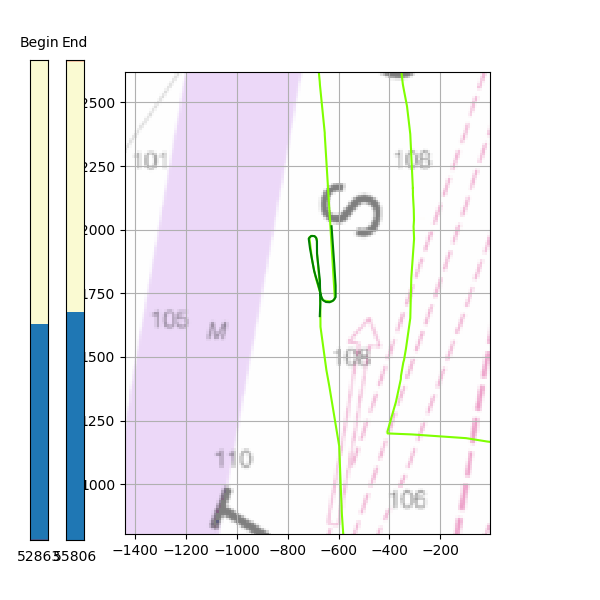

In [96]:
# Let's start out by looking at a particular day, when we were on motor and we performed a 
# maneuver, looping back over are course.

date = '2020-04-19'
df, race = race_logs.read_date(date)
ch = chart.trim_track(df)

# The interface below can be used to trim the track.  Notice the loop near 1800 North, and 680 West.

In [97]:
ch.begin, ch.end

(52863, 55806)

In [4]:
import importlib
importlib.reload(chart)

<module 'chart' from '/Users/viola/GDrive/Sailboat/Code/Python/sailing/chart.py'>

<IPython.core.display.Javascript object>


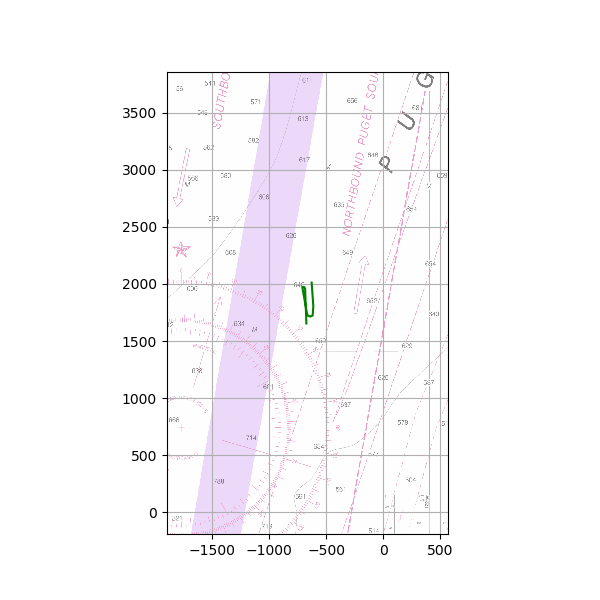

In [99]:
# This loop can be trimmed out as follows:

ss = slice(52863, 55806)
tdf = df.iloc[ss]

_ = chart.plot_chart(tdf, border=0.5)


<IPython.core.display.Javascript object>


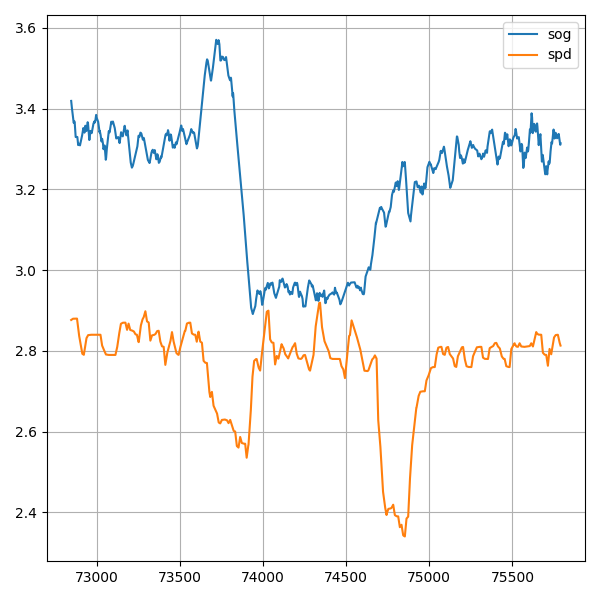

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [100]:
# And we can plot the boat's two measures of speed during that time.

chart.quick_plot(tdf.index, (tdf.sog, tdf.spd), "sog spd".split())

### Not Equal

As we can see, the SOG does not equal SPD.  There are two main causes for this difference.

- Current:  The boat is moving through water which is itself moving.
- Calibration:  Speed is not correctly reported by the SPD sensor (a paddle wheel).

If we were sailing, which we were not, there would have been a third:

- Leeway: The tendency of the boat to slip sideway "to leeward" when sailing upwind.  This is not measured by the SPD sensor.

First observe that outside of the turns, the SPD is relatively constant.  We were moving through the water on motor with no changes in throttle.

The turns themselves are likely complex, and we should consider removing them.


<IPython.core.display.Javascript object>


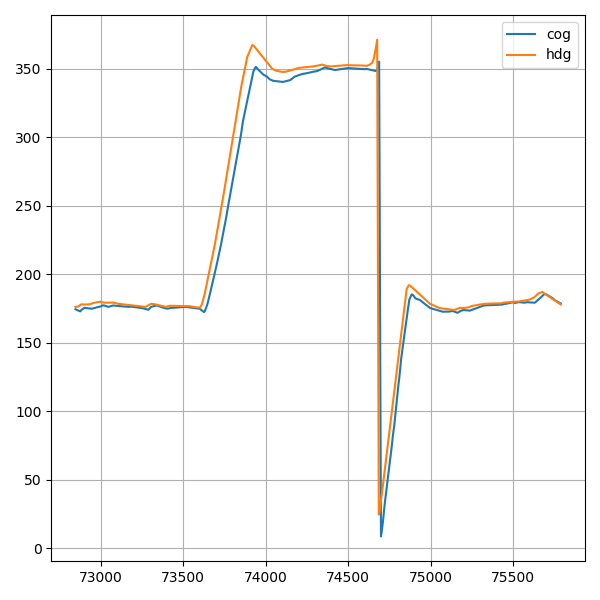

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [101]:
# The turns can be easily seen in the COG and HDG.

# Note, HDG is magnetic.  And boat instruments report variation as a convenience. I believe it is simply a lookup in a table.  I do not believe the table is is particularly accurate and it is old, but its a start.
variation = tdf.variation.mean()

chart.quick_plot(tdf.index, (tdf.cog, tdf.hdg+variation), "cog hdg".split())

13


<IPython.core.display.Javascript object>


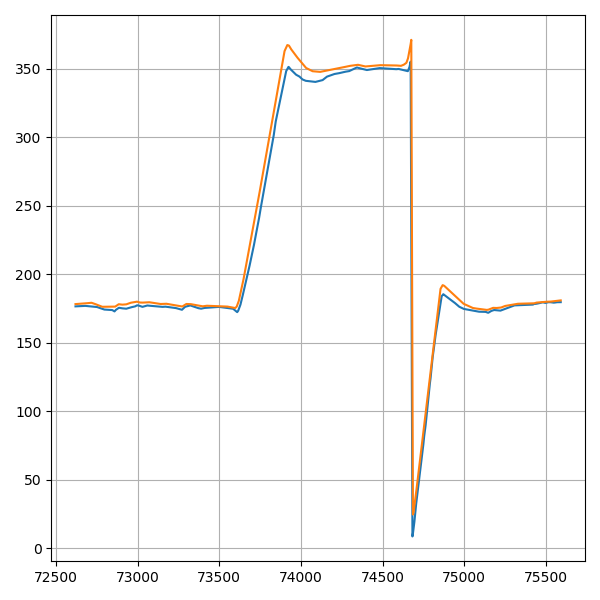

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [26]:
# There is a clear delay in the signals.  We can estimate that delay, as we do below.

delay, _ = a.find_signal_delay(tdf.cog, tdf.hdg+variation)
print(delay)

# note in similar analyses we have found about 16 samples of delay, or 1.6 seconds!

delay = 16
index = tdf.index[:-delay]
cog = tdf.iloc[delay:].cog
sog = tdf.iloc[delay:].sog
hdg = tdf.iloc[:-delay].hdg+variation
spd = tdf.iloc[:-delay].spd

chart.quick_plot(index, (cog, hdg))

<IPython.core.display.Javascript object>


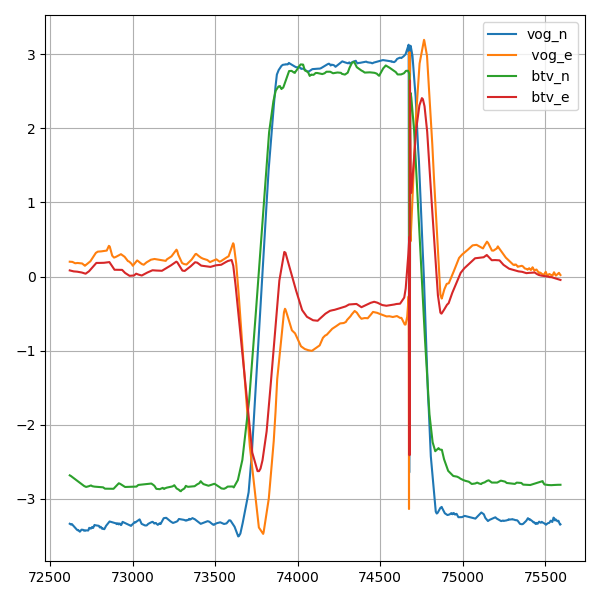

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [102]:
# To simplify the analysis, we will decompose the boats motion north and east components.

vog_n = sog * p.north_d(cog)
vog_e = sog * p.east_d(cog)

btv_n = spd * p.north_d(hdg)
btv_e = spd * p.east_d(hdg)

chart.quick_plot(index, (vog_n, vog_e, btv_n, btv_e), "vog_n, vog_e, btv_n, btv_e")

-0.32303041160759327 -0.028039979974976998


<IPython.core.display.Javascript object>


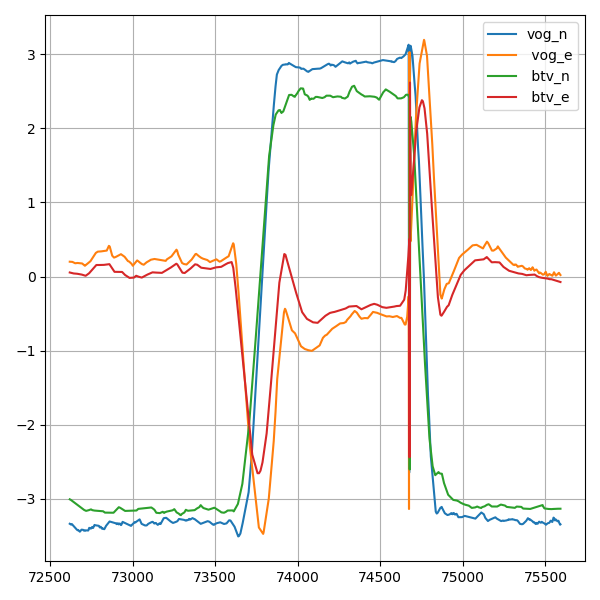

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [29]:
# One simple way to estimate current is to take the average difference between the components.

cur_n = (vog_n - btv_n).mean()
cur_e = (vog_e - btv_e).mean()

print(cur_n, cur_e)

chart.quick_plot(index, (vog_n, vog_e, btv_n+cur_n, btv_e+cur_e), "vog_n, vog_e, btv_n, btv_e")

### Improved, but far from perfect

We likely need to estimate both the current **and** the calibration.  

For the time being we will assume that the calibration is a single multiplier.  

Later, we can consider adding an offset, or perhaps some other non-linearities.  It is also possible that SPD is dependent on heel (reading higher on PORT or STBD tacks).

In [126]:
# We can directly optimize the current and multiplier in an effort to reduce the error (or mismatch) between the SOG/COG and SPD/HDG.

from scipy.optimize import minimize
import numpy as np

tdf = df.iloc[ss]
tdf = tdf[tdf.spd > 2.7]

def create_error_func(tdf):
    delay = 16
    index = tdf.index[:-delay]
    cog = tdf.iloc[delay:].cog
    sog = tdf.iloc[delay:].sog

    hdg = tdf.iloc[:-delay].hdg+variation
    spd = tdf.iloc[:-delay].spd

    vog_n = sog * p.north_d(cog)
    vog_e = sog * p.east_d(cog)

    btv_n = spd * p.north_d(hdg)
    btv_e = spd * p.east_d(hdg)

    def error(params):
        cur_n = params[0]
        cur_e = params[1]
        multiplier = params[2]
        # These are the residuals 
        r_n = vog_n - (multiplier * btv_n + cur_n)
        r_e = vog_e - (multiplier * btv_e + cur_e)
        return np.sum(np.square(r_n)) + np.sum(np.square(r_e))
    
    return error

error = create_error_func(tdf)
# Initial parameters
m0 = np.array([0, 0, 1.0])
print(error(m0))
res = minimize(error, m0, options=dict(disp=True))
                   # options={'xatol': 1e-5, 'disp': True})
    
params = res.x
cur_n = params[0]
cur_e = params[1]
multiplier = params[2]


0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1


In [127]:
print(params)
print(error(params))
print(error(m0))
print(cur_n, cur_e, multiplier)

[0. 0. 1.]
0.0
0.0
0.0 0.0 1.0


<IPython.core.display.Javascript object>


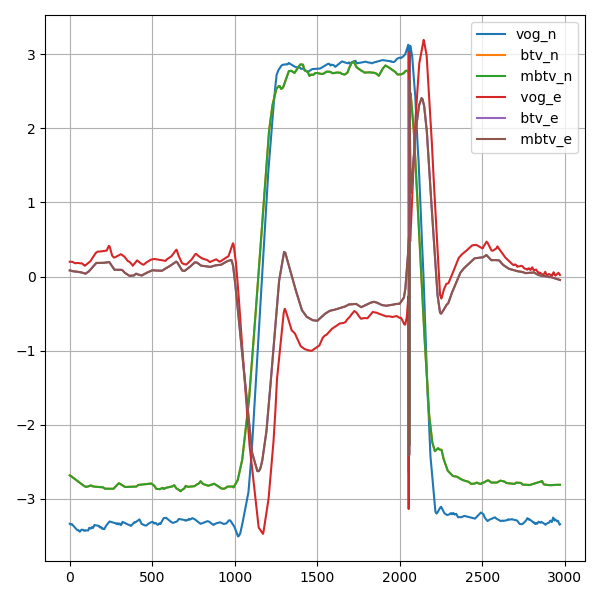

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [128]:
chart.quick_plot(None, (vog_n, btv_n, multiplier*btv_n+cur_n, vog_e, btv_e, multiplier*btv_e+cur_e), "vog_n, btv_n, mbtv_n, vog_e, btv_e, mbtv_e")

### Much better. North and East Residuals are Different?

Note the blue and green (north) curves are a much better match.  But the red/brown (east) are still off.

East/West speed seems to be underestimated, not sure why. The boat is mostly pointed north/south except in the turns.  Perhaps the boat is slipping sideways even under motor.

In [129]:
# We can re-run this analysis for the entire day's sail.  The problem is that current is almost certainly 
# not constant throughout the day.

date = '2020-05-16'
df, race = race_logs.read_date(date)

error = create_error_func(df)
# Initial parameters
m0 = np.array([0, 0, 1.0])
print(error(m0))
res = minimize(error, m0, options=dict(disp=True))
                   # options={'xatol': 1e-5, 'disp': True})
    
params = res.x
print(params)
print(error(params))
print(error(m0))

2020-06-11 16:33:23,694|INFO|read_metadata| Read 50 records.
2020-06-11 16:33:23,694|INFO|read_logs| Reading file 2020-05-16_10:06.pd.gz


Session from 2020-05-16 17:06:48.040000, 162526 rows, 4.514444444444444 hours.


2020-06-11 16:33:25,126|INFO|read_logs| Found 162516 records before trim.
2020-06-11 16:33:25,150|INFO|read_logs| Trimming to 9771 146553


26745.012295246834
         Current function value: 19311.020659
         Iterations: 4
         Function evaluations: 51
         Gradient evaluations: 10
[-0.1401 -0.169   1.1375]
19311.020659198814
26745.012295246834


In [131]:
df.spd.max()

2.5989336413819584

In [135]:
def create_error_func(tdf):
    delay = 16
    index = tdf.index[:-delay]
    cog = tdf.iloc[delay:].cog
    sog = tdf.iloc[delay:].sog

    hdg = tdf.iloc[:-delay].hdg+variation
    spd = tdf.iloc[:-delay].spd

    vog_n = sog * p.north_d(cog)
    vog_e = sog * p.east_d(cog)

    btv_n = spd * p.north_d(hdg)
    btv_e = spd * p.east_d(hdg)
    btv_switch = spd < 1.0
    print(btv_switch.sum(), (1-btv_switch).sum())

    def error(params):
        cur_n = params[0]
        cur_e = params[1]
        m0 = params[2]
        m1 = params[3]
        multiplier = (btv_switch * m0) + ((1-btv_switch) * m1)
        # These are the residuals 
        r_n = vog_n - (multiplier * btv_n + cur_n)
        r_e = vog_e - (multiplier * btv_e + cur_e)
        return np.sum(np.square(r_n)) + np.sum(np.square(r_e))
    
    return error


tdf = df[df.spd > 0.5]
error = create_error_func(tdf)
# Initial parameters
m0 = np.array([0, 0, 1.0, 1.0])
res = minimize(error, m0, options=dict(disp=True))

params = res.x
print(params)
print(error(params))
print(error(m0))

23912 43764
         Current function value: 4791.563746
         Iterations: 5
         Function evaluations: 79
         Gradient evaluations: 13
[-0.1794 -0.1295  1.3109  1.1031]
4791.563746023065
9766.568195540978


<IPython.core.display.Javascript object>


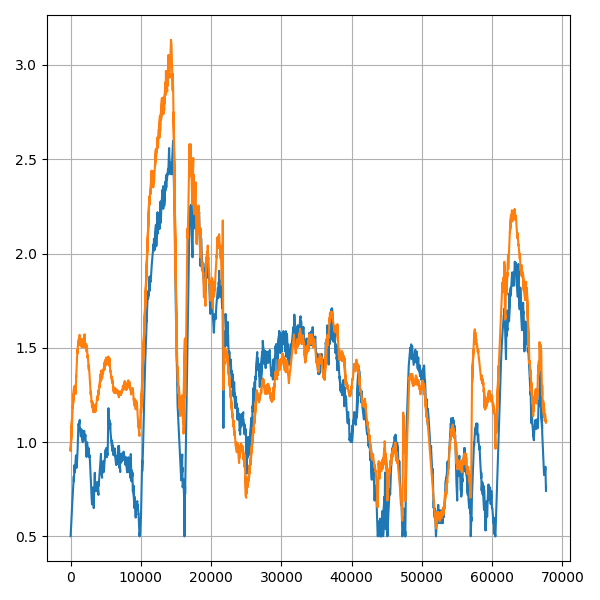

{'trim_func': <function chart.quick_plot_ax.<locals>.trim_func(*args)>,
 'update_func': <function chart.quick_plot_ax.<locals>.update_func(begin, end)>}

In [136]:
chart.quick_plot(None, (tdf.spd, tdf.sog))

In [119]:
btv_switch = (spd < 1.0)

In [121]:
(btv_switch * 1) + ((1-btv_switch) * 2)

72620    2
72621    2
72622    2
72623    2
72624    2
        ..
75587    2
75588    2
75589    2
75590    2
75591    2
Name: spd, Length: 2972, dtype: int64